# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [15]:
# Import warnings

import warnings
warnings.filterwarnings("ignore")

In [17]:
# Import the libraries you will be using for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.9.2
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [23]:
# Try loading one file

# df = pd.read_parquet('2023-1.parquet')
# df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [30]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [32]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
import pandas as pd
import os

# Set path where parquet files are stored
folder_path = "./"  # update if needed
file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.parquet')])

# Empty list to collect all samples
final_sampled_data = []

# Process each file
for file in file_list:
    try:
        df = pd.read_parquet(os.path.join(folder_path, file))

        # Convert datetime column
        df['pickup_dt'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['pickup_date'] = df['pickup_dt'].dt.date
        df['pickup_hour'] = df['pickup_dt'].dt.hour

        # Sample 5% per hour per day
        sampled_month = pd.DataFrame()
        for date in df['pickup_date'].unique():
            day_data = df[df['pickup_date'] == date]
            for hour in range(24):
                hour_data = day_data[day_data['pickup_hour'] == hour]
                if not hour_data.empty:
                    sample = hour_data.sample(frac=0.05, random_state=42)
                    sampled_month = pd.concat([sampled_month, sample], ignore_index=True)

        final_sampled_data.append(sampled_month)

        print(f" Sampled from: {file} → Rows: {sampled_month.shape[0]}")

    except Exception as e:
        print(f" Error processing {file}: {e}")

# Combine all monthly samples
combined_df = pd.concat(final_sampled_data, ignore_index=True)
print(" Final Combined Sample Shape:", combined_df.shape)
combined_df.head()


 Sampled from: yellow_tripdata_2023-01.parquet → Rows: 153336
 Sampled from: yellow_tripdata_2023-02.parquet → Rows: 145690
 Sampled from: yellow_tripdata_2023-03.parquet → Rows: 170184
 Sampled from: yellow_tripdata_2023-04.parquet → Rows: 164410
 Sampled from: yellow_tripdata_2023-05.parquet → Rows: 175683
 Sampled from: yellow_tripdata_2023-06.parquet → Rows: 165362
 Sampled from: yellow_tripdata_2023-07.parquet → Rows: 145348
 Sampled from: yellow_tripdata_2023-08.parquet → Rows: 141219
 Sampled from: yellow_tripdata_2023-09.parquet → Rows: 142340
 Sampled from: yellow_tripdata_2023-10.parquet → Rows: 176117
 Sampled from: yellow_tripdata_2023-11.parquet → Rows: 166986
 Sampled from: yellow_tripdata_2023-12.parquet → Rows: 168836
 Final Combined Sample Shape: (1915511, 23)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_dt,pickup_date,pickup_hour,Airport_fee
0,2,2023-01-01 00:10:30,2023-01-01 00:11:49,1.0,0.49,1.0,N,239,238,1,...,1.88,0.00,1.0,11.28,2.5,0.0,2023-01-01 00:10:30,2023-01-01,0,NaN
1,2,2023-01-01 00:49:02,2023-01-01 00:55:15,1.0,0.75,1.0,N,45,148,2,...,0.00,0.00,1.0,12.90,2.5,0.0,2023-01-01 00:49:02,2023-01-01,0,NaN
2,1,2023-01-01 00:47:17,2023-01-01 01:07:01,2.0,2.90,1.0,N,142,170,1,...,4.80,0.00,1.0,28.90,2.5,0.0,2023-01-01 00:47:17,2023-01-01,0,NaN
3,2,2023-01-01 00:06:02,2023-01-01 00:31:38,1.0,2.50,1.0,N,43,161,1,...,7.25,0.00,1.0,36.25,2.5,0.0,2023-01-01 00:06:02,2023-01-01,0,NaN
4,2,2023-01-01 00:02:19,2023-01-01 00:30:49,1.0,20.37,2.0,N,132,140,1,...,12.00,6.55,1.0,92.55,2.5,0.0,2023-01-01 00:02:19,2023-01-01,0,NaN


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [37]:
# Store the df in csv/parquet
# df.to_parquet('')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [41]:
# Load the new data file



In [43]:
# df.head()
combined_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_dt,pickup_date,pickup_hour,Airport_fee
0,2,2023-01-01 00:10:30,2023-01-01 00:11:49,1.0,0.49,1.0,N,239,238,1,...,1.88,0.00,1.0,11.28,2.5,0.0,2023-01-01 00:10:30,2023-01-01,0,NaN
1,2,2023-01-01 00:49:02,2023-01-01 00:55:15,1.0,0.75,1.0,N,45,148,2,...,0.00,0.00,1.0,12.90,2.5,0.0,2023-01-01 00:49:02,2023-01-01,0,NaN
2,1,2023-01-01 00:47:17,2023-01-01 01:07:01,2.0,2.90,1.0,N,142,170,1,...,4.80,0.00,1.0,28.90,2.5,0.0,2023-01-01 00:47:17,2023-01-01,0,NaN
3,2,2023-01-01 00:06:02,2023-01-01 00:31:38,1.0,2.50,1.0,N,43,161,1,...,7.25,0.00,1.0,36.25,2.5,0.0,2023-01-01 00:06:02,2023-01-01,0,NaN
4,2,2023-01-01 00:02:19,2023-01-01 00:30:49,1.0,20.37,2.0,N,132,140,1,...,12.00,6.55,1.0,92.55,2.5,0.0,2023-01-01 00:02:19,2023-01-01,0,NaN


In [45]:
# df.info()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915511 entries, 0 to 1915510
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [49]:
# Fix the index and drop any columns that are not needed
# Reset index to ensure it's sequential
combined_df.reset_index(drop=True, inplace=True)

# Drop unnecessary/redundant columns
columns_to_drop = ['pickup_dt', 'pickup_date', 'Airport_fee']

combined_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Confirm structure
print(" Cleaned shape after dropping:", combined_df.shape)
combined_df.head(2)



 Cleaned shape after dropping: (1915511, 20)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_hour
0,2,2023-01-01 00:10:30,2023-01-01 00:11:49,1.0,0.49,1.0,N,239,238,1,4.4,1.0,0.5,1.88,0.0,1.0,11.28,2.5,0.0,0
1,2,2023-01-01 00:49:02,2023-01-01 00:55:15,1.0,0.75,1.0,N,45,148,2,7.9,1.0,0.5,0.00,0.0,1.0,12.90,2.5,0.0,0


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [52]:
# Combine the two airport fee columns

# Check columns
print("Available columns:", combined_df.columns.tolist())

# Safe merge logic
if 'airport_fee' in combined_df.columns and 'Airport_fee' in combined_df.columns:
    # Combine both by summing non-null values
    combined_df['airport_fee_combined'] = combined_df['airport_fee'].fillna(0) + combined_df['Airport_fee'].fillna(0)
    combined_df.drop(columns=['airport_fee', 'Airport_fee'], inplace=True)
    combined_df.rename(columns={'airport_fee_combined': 'airport_fee'}, inplace=True)
    print(" Merged 'airport_fee' and 'Airport_fee' into one unified column.")

elif 'Airport_fee' in combined_df.columns:
    combined_df.rename(columns={'Airport_fee': 'airport_fee'}, inplace=True)
    print(" Only 'Airport_fee' existed. Renamed to 'airport_fee'.")

elif 'airport_fee' in combined_df.columns:
    print(" Only 'airport_fee' column exists. No action needed.")

else:
    print(" No airport fee-related columns found.")


Available columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'pickup_hour']
 Only 'airport_fee' column exists. No action needed.


**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [55]:
# check where values of fare amount are negative

negative_fares = combined_df[combined_df['fare_amount'] < 0]
print(" Total negative fare entries:", negative_fares.shape[0])
negative_fares[['fare_amount', 'RatecodeID']].head()


 Total negative fare entries: 19056


,fare_amount,RatecodeID
51,-26.1,1.0
138,-14.2,1.0
170,-43.6,1.0
174,-39.4,4.0
218,-21.9,1.0


Did you notice something different in the `RatecodeID` column for above records?

In [58]:
# Analyse RatecodeID for the negative fare amounts

negative_fares['RatecodeID'].value_counts()


RatecodeID
1.0    16721
2.0     1324
5.0      369
3.0      223
4.0       88
Name: count, dtype: int64

In [60]:
# Find which columns have negative values

numeric_cols = combined_df.select_dtypes(include=['number']).columns

# Find count of negative values in each column
negative_summary = {
    col: (combined_df[col] < 0).sum()
    for col in numeric_cols
    if (combined_df[col] < 0).any()
}

# Show columns with negative values
negative_summary


{'fare_amount': 19056,
 'extra': 9472,
 'mta_tax': 18241,
 'tip_amount': 117,
 'tolls_amount': 1203,
 'improvement_surcharge': 18829,
 'total_amount': 18840,
 'congestion_surcharge': 15051,
 'airport_fee': 175}

In [62]:
# fix these negative values

# Drop rows with negative values in any monetary column
# We'll focus on key fare-related columns

monetary_cols = [
    'fare_amount', 'tip_amount', 'tolls_amount',
    'total_amount', 'extra', 'congestion_surcharge'
]

# Remove rows with any negative values in these columns
for col in monetary_cols:
    combined_df = combined_df[combined_df[col] >= 0]

print(" Final shape after removing negative monetary values:", combined_df.shape)


 Final shape after removing negative monetary values: (1831541, 20)


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [66]:
# Find the proportion of missing values in each column

# Count missing values
missing_count = combined_df.isnull().sum()

# Calculate % of missing
missing_percent = (missing_count / len(combined_df)) * 100

# Combine into a table
missing_df = pd.DataFrame({
    'missing_count': missing_count,
    'missing_percent': missing_percent.round(2)
})

# Show only columns with missing values
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values(by='missing_percent', ascending=False)
missing_df


,missing_count,missing_percent
airport_fee,1683056,91.89


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [69]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'

# Fill missing values with mode
passenger_mode = combined_df['passenger_count'].mode()[0]
combined_df['passenger_count'].fillna(passenger_mode, inplace=True)

# Remove rows where passenger_count is zero
combined_df = combined_df[combined_df['passenger_count'] != 0]

print(f" Filled NaNs with mode = {passenger_mode} and removed rows with 0 passengers.")



 Filled NaNs with mode = 1.0 and removed rows with 0 passengers.


Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [73]:
# Fix missing values in 'RatecodeID'

ratecode_mode = combined_df['RatecodeID'].mode()[0]
combined_df['RatecodeID'].fillna(ratecode_mode, inplace=True)

print(f" Filled missing RatecodeID with mode = {ratecode_mode}")


 Filled missing RatecodeID with mode = 1.0


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [76]:
# handle null values in congestion_surcharge

# Fill NaNs with mode
surcharge_mode = combined_df['congestion_surcharge'].mode()[0]
combined_df['congestion_surcharge'].fillna(surcharge_mode, inplace=True)

print(f" Filled missing congestion_surcharge with mode = {surcharge_mode}")




 Filled missing congestion_surcharge with mode = 2.5


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [79]:
# Handle any remaining missing values

# Show remaining columns with nulls
remaining_nulls = combined_df.isnull().sum()
remaining_nulls = remaining_nulls[remaining_nulls > 0]
print(" Remaining null values:\n", remaining_nulls)

# Drop column with too many missing values
if 'airport_fee' in remaining_nulls.index and remaining_nulls['airport_fee'] > (0.9 * len(combined_df)):
    combined_df.drop(columns='airport_fee', inplace=True)
    print(" Dropped 'airport_fee' column due to high missing percentage.")



 Remaining null values:
 airport_fee    1656025
dtype: int64
 Dropped 'airport_fee' column due to high missing percentage.


### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [83]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

print("Zero or negative fare amounts:", (combined_df['fare_amount'] <= 0).sum())
print("Trips with 0 or negative distance:", (combined_df['trip_distance'] <= 0).sum())
print("Tips > fare amounts:", (combined_df['tip_amount'] > combined_df['fare_amount']).sum())
print("Passenger count > 6:", (combined_df['passenger_count'] > 6).sum())



Zero or negative fare amounts: 515
Trips with 0 or negative distance: 22208
Tips > fare amounts: 2247
Passenger count > 6: 13


**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [88]:
# remove passenger_count > 6
combined_df = combined_df[combined_df['passenger_count'] <= 6]
print(" Removed trips with passenger_count > 6. New shape:", combined_df.shape)


 Removed trips with passenger_count > 6. New shape: (1801941, 19)


In [90]:
# Continue with outlier handling

# Remove trips with distance nearly 0 but very high fare
combined_df = combined_df[~((combined_df['trip_distance'] < 0.1) & (combined_df['fare_amount'] > 300))]

# Remove trips where distance and fare are 0 but pickup & dropoff zones are different
combined_df = combined_df[~(
    (combined_df['trip_distance'] == 0) &
    (combined_df['fare_amount'] == 0) &
    (combined_df['PULocationID'] != combined_df['DOLocationID'])
)]

# Remove trips with distance > 250 miles
combined_df = combined_df[combined_df['trip_distance'] <= 250]

# Remove records with invalid payment_type = 0
combined_df = combined_df[combined_df['payment_type'] != 0]

print(" Applied custom rules to fix outliers. New shape:", combined_df.shape)


 Applied custom rules to fix outliers. New shape: (1801805, 19)


In [92]:
# Do any columns need standardising?

# Example: Check amount columns for high range
amount_cols = ['fare_amount', 'tip_amount', 'tolls_amount', 'total_amount']

combined_df[amount_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
fare_amount,1801805.0,19.781852,18.298349,0.0,9.30,13.50,21.90,904.60
tip_amount,1801805.0,3.582208,4.069891,0.0,1.00,2.86,4.45,411.10
tolls_amount,1801805.0,0.598060,2.185051,0.0,0.00,0.00,0.00,104.75
total_amount,1801805.0,28.917937,22.931097,0.0,15.96,21.00,30.72,906.10


## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [95]:
# View final cleaned column names
combined_df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'pickup_hour']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

In [99]:
# Define categories manually based on column types and meaning

numerical_columns = [
    'passenger_count', 'trip_distance', 'pickup_hour', 'trip_duration',
    'fare_amount', 'extra', 'mta_tax', 'tip_amount',
    'tolls_amount', 'improvement_surcharge', 'total_amount',
    'congestion_surcharge', 'airport_fee'
]

categorical_columns = [
    'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type'
]

print(" Numerical Columns:\n", numerical_columns)
print("\n Categorical Columns:\n", categorical_columns)


 Numerical Columns:
 ['passenger_count', 'trip_distance', 'pickup_hour', 'trip_duration', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']

 Categorical Columns:
 ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type']


##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure pickup datetime is in datetime format
combined_df['tpep_pickup_datetime'] = pd.to_datetime(combined_df['tpep_pickup_datetime'])

# Create time-based columns
combined_df['pickup_hour'] = combined_df['tpep_pickup_datetime'].dt.hour
combined_df['pickup_day'] = combined_df['tpep_pickup_datetime'].dt.day_name()
combined_df['pickup_month'] = combined_df['tpep_pickup_datetime'].dt.month_name()

# Set plot style
sns.set(style="whitegrid", palette="Set2")

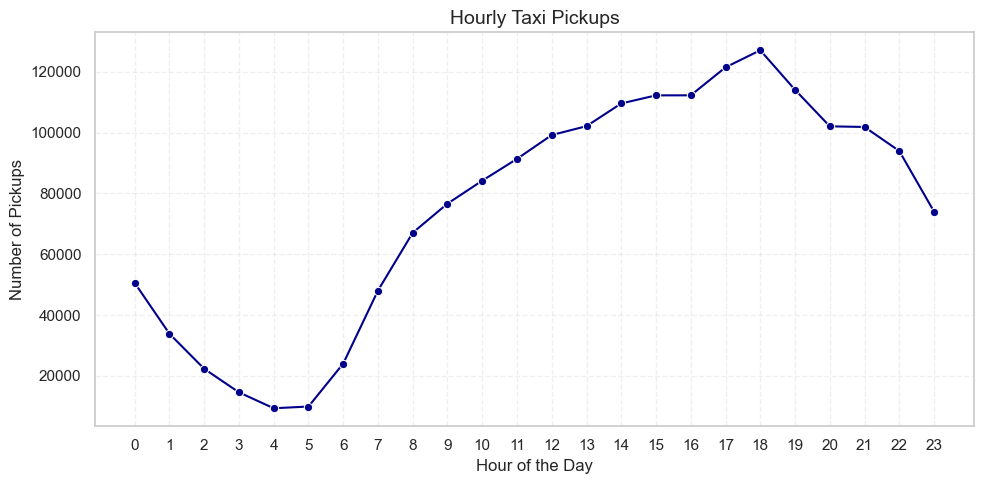

In [109]:
# Find and show the hourly trends in taxi pickups
hourly_counts = combined_df['pickup_hour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o', color='darkblue')
plt.title("Hourly Taxi Pickups", fontsize=14)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Pickups")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


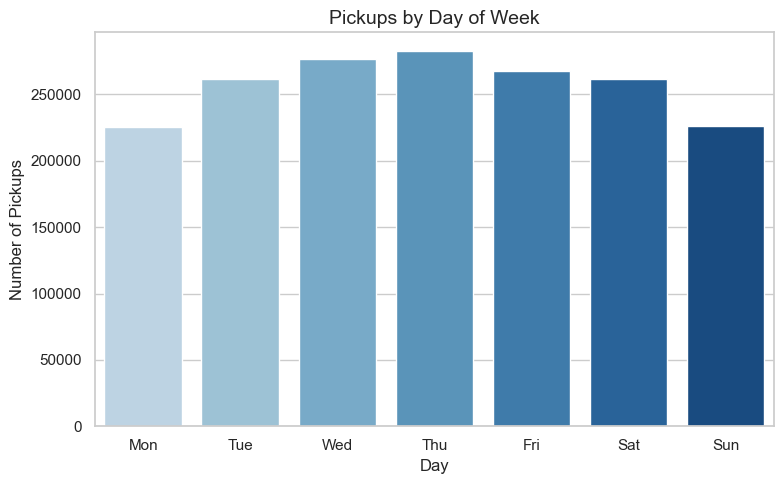

In [111]:
# Find and show the daily trends in taxi pickups (days of the week)
# Daily pickups (0=Mon, 6=Sun)
combined_df['day_of_week'] = combined_df['tpep_pickup_datetime'].dt.dayofweek
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_counts = combined_df['day_of_week'].value_counts().sort_index()
daily_counts.index = day_order

# Use a more visible range of Blues (skip lightest 0 and 1)
colors = sns.color_palette("Blues", 9)[2:9]  # Picks from index 2 to 8 (mid to dark)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=daily_counts.index, y=daily_counts.values, palette=colors)
plt.title("Pickups by Day of Week", fontsize=14)
plt.xlabel("Day")
plt.ylabel("Number of Pickups")
plt.tight_layout()
plt.show()

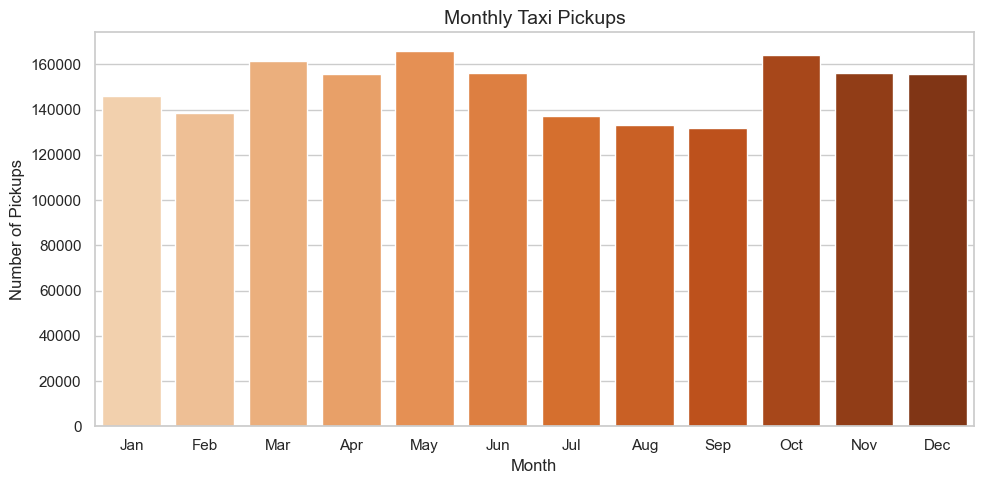

In [113]:
# Show the monthly trends in pickups
# Extract month
combined_df['pickup_month'] = combined_df['tpep_pickup_datetime'].dt.month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_counts = combined_df['pickup_month'].value_counts().sort_index()
monthly_counts.index = month_names

# Get better visible shades by skipping whites
colors = sns.color_palette("Oranges", 15)[3:15]  # picks index 3 to 14 (total 12 shades)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette=colors)
plt.title("Monthly Taxi Pickups", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Pickups")
plt.tight_layout()
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [117]:
# Analyse the above parameters

financial_cols = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

# Summary and zero/negative check
summary_stats = combined_df[financial_cols].describe()
zero_negative_counts = (combined_df[financial_cols] <= 0).sum()

print(" Summary Statistics:\n", summary_stats)
print("\n Zero/Negative Values:\n", zero_negative_counts)


 Summary Statistics:
         fare_amount    tip_amount  total_amount  trip_distance
count  1.801805e+06  1.801805e+06  1.801805e+06   1.801805e+06
mean   1.978185e+01  3.582208e+00  2.891794e+01   3.454563e+00
std    1.829835e+01  4.069891e+00  2.293110e+01   4.559277e+00
min    0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
25%    9.300000e+00  1.000000e+00  1.596000e+01   1.050000e+00
50%    1.350000e+01  2.860000e+00  2.100000e+01   1.780000e+00
75%    2.190000e+01  4.450000e+00  3.072000e+01   3.380000e+00
max    9.046000e+02  4.111000e+02  9.061000e+02   2.238100e+02

 Zero/Negative Values:
 fare_amount         443
tip_amount       402070
total_amount        237
trip_distance     22084
dtype: int64


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [121]:
# Create a df with non zero entries for the selected parameters.
# Create a DataFrame with non-zero entries for fare, tip, total amount, and distance
non_zero_df = combined_df[
    (combined_df['fare_amount'] > 0) &
    (combined_df['tip_amount'] > 0) &
    (combined_df['total_amount'] > 0) &
    (combined_df['trip_distance'] > 0)
].copy()

# Show the shape of the new DataFrame
print("Original Dataset Shape:", combined_df.shape)
print("Filtered Dataset Shape (Non-zero entries):", non_zero_df.shape)

Original Dataset Shape: (1801805, 22)
Filtered Dataset Shape (Non-zero entries): (1391634, 22)


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

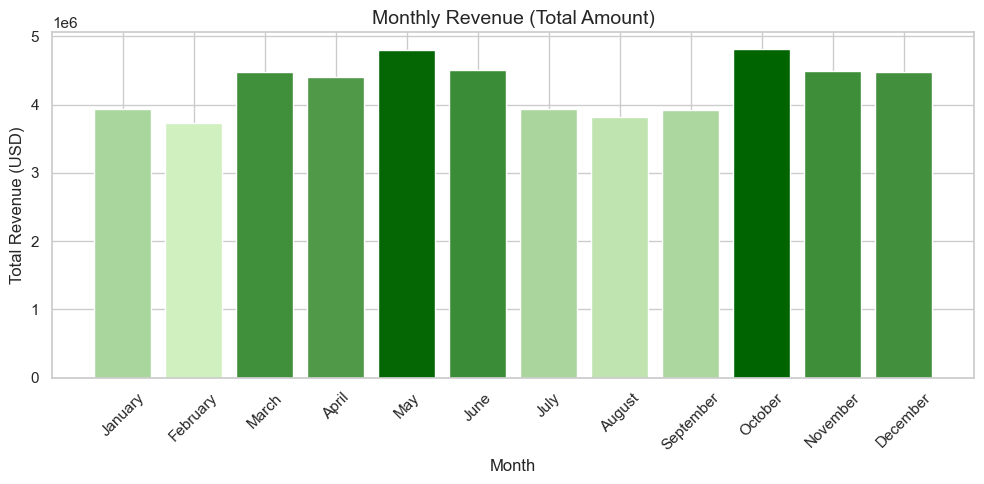

In [271]:
# Group data by month and analyse monthly revenue

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from calendar import month_name  # <-- Ye line add karo

# Extract month
combined_df['pickup_month'] = combined_df['tpep_pickup_datetime'].dt.month_name()

# Group total revenue by month
monthly_revenue = combined_df.groupby('pickup_month')['total_amount'].sum()

#  Sort in calendar order
ordered_months = list(month_name)[1:]  # Skip empty string at index 0
monthly_revenue = monthly_revenue.reindex(ordered_months)

#  Normalize values
norm = (monthly_revenue - monthly_revenue.min()) / (monthly_revenue.max() - monthly_revenue.min())

#  Generate green gradient based on values (light to dark)
green_cmap = LinearSegmentedColormap.from_list("green_gradient", ["#d0f0c0", "#006400"])
colors = [green_cmap(x) for x in norm]

#  Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(monthly_revenue.index, monthly_revenue.values, color=colors)
plt.title("Monthly Revenue (Total Amount)", fontsize=14)
plt.ylabel("Total Revenue (USD)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

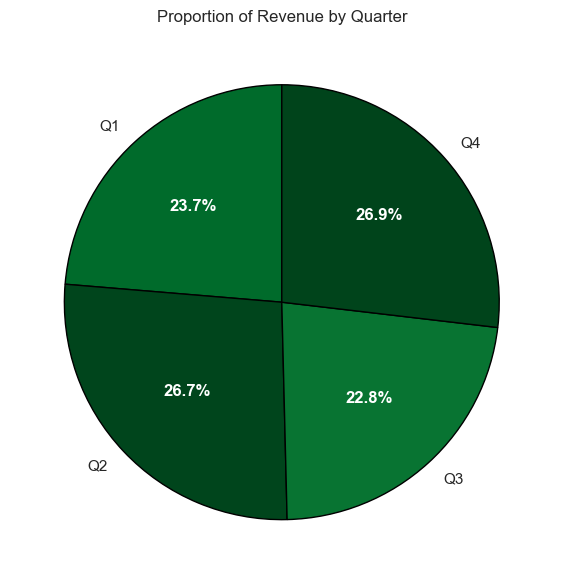

In [269]:
# Calculate proportion of each quarter

# First, ensure the datetime column is parsed correctly
combined_df['tpep_pickup_datetime'] = pd.to_datetime(combined_df['tpep_pickup_datetime'])

# Extract the quarter from the pickup datetime
combined_df['quarter'] = combined_df['tpep_pickup_datetime'].dt.quarter

# Group by quarter and sum the total_amount
quarterly_revenue = combined_df.groupby('quarter')['total_amount'].sum().reset_index()

# Calculate percentage contribution
quarterly_revenue['proportion'] = (quarterly_revenue['total_amount'] / quarterly_revenue['total_amount'].sum()) * 100

# Plot as a pie chart to show proportion clearly
import matplotlib.pyplot as plt

colors = plt.cm.Greens(quarterly_revenue['proportion'] / quarterly_revenue['proportion'].max())  # Green gradient

plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    quarterly_revenue['proportion'],
    labels=[f'Q{q}' for q in quarterly_revenue['quarter']],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)

#  Set the autopct labels to white and bold for better contrast
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.title('Proportion of Revenue by Quarter')
plt.tight_layout()
plt.show()

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

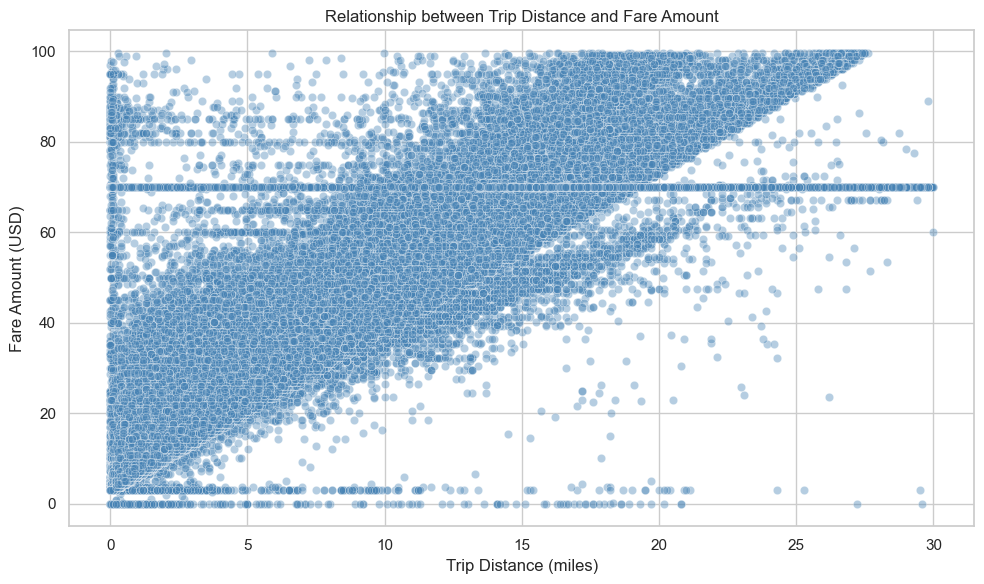

Correlation between trip_distance and fare_amount: 0.95


In [132]:
# Show how trip fare is affected by distance

import matplotlib.pyplot as plt
import seaborn as sns

# Filter out zero or negative distances
filtered_df = combined_df[combined_df['trip_distance'] > 0]

# Optional: Also remove outliers (for better plot readability)
filtered_df = filtered_df[(filtered_df['trip_distance'] < 30) & (filtered_df['fare_amount'] < 100)]

# Scatter plot to show relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='trip_distance', y='fare_amount', alpha=0.4, color='steelblue')
plt.title('Relationship between Trip Distance and Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation value
correlation = filtered_df['trip_distance'].corr(filtered_df['fare_amount'])
print(f"Correlation between trip_distance and fare_amount: {correlation:.2f}")

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

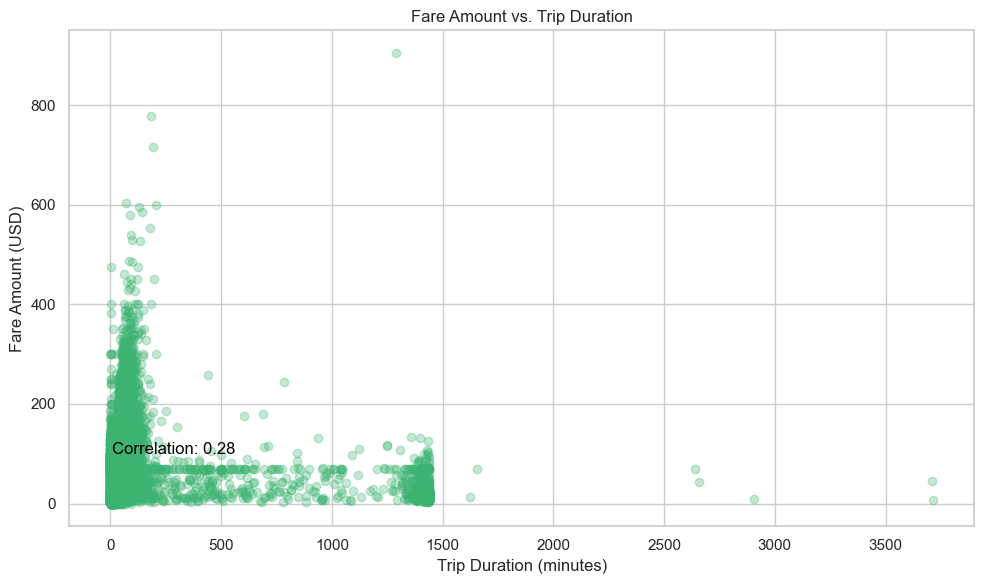

In [267]:
# Show relationship between fare and trip duration

# Ensure datetime columns are in proper format
combined_df['tpep_pickup_datetime'] = pd.to_datetime(combined_df['tpep_pickup_datetime'])
combined_df['tpep_dropoff_datetime'] = pd.to_datetime(combined_df['tpep_dropoff_datetime'])

# Calculate trip duration in minutes
combined_df['trip_duration'] = (combined_df['tpep_dropoff_datetime'] - combined_df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Filter out non-positive durations
duration_df = combined_df[combined_df['trip_duration'] > 0]

# Correlation and plot
import matplotlib.pyplot as plt

correlation1 = duration_df['fare_amount'].corr(duration_df['trip_duration'])

plt.figure(figsize=(10, 6))
plt.scatter(duration_df['trip_duration'], duration_df['fare_amount'], alpha=0.3, color='mediumseagreen')
plt.title('Fare Amount vs. Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount (USD)')
plt.text(5, 100, f'Correlation: {correlation1:.2f}', fontsize=12, color='black')
plt.grid(True)
plt.tight_layout()
plt.show()

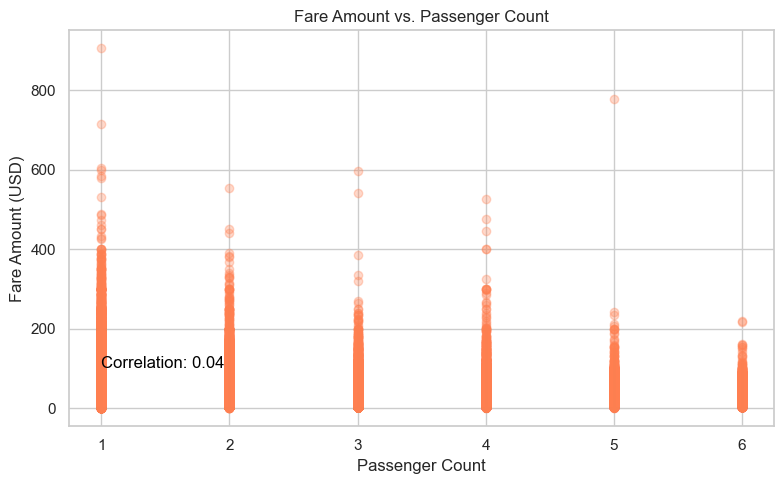

In [265]:
# Show relationship between fare and number of passengers

# Filter out zero or negative passenger counts (if any)
passenger_df = combined_df[combined_df['passenger_count'] > 0]

# Correlation and plot
correlation2 = passenger_df['fare_amount'].corr(passenger_df['passenger_count'])

plt.figure(figsize=(8, 5))
plt.scatter(passenger_df['passenger_count'], passenger_df['fare_amount'], alpha=0.3, color='coral')
plt.title('Fare Amount vs. Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount (USD)')
plt.text(1, 100, f'Correlation: {correlation2:.2f}', fontsize=12, color='black')
plt.grid(True)
plt.tight_layout()
plt.show()

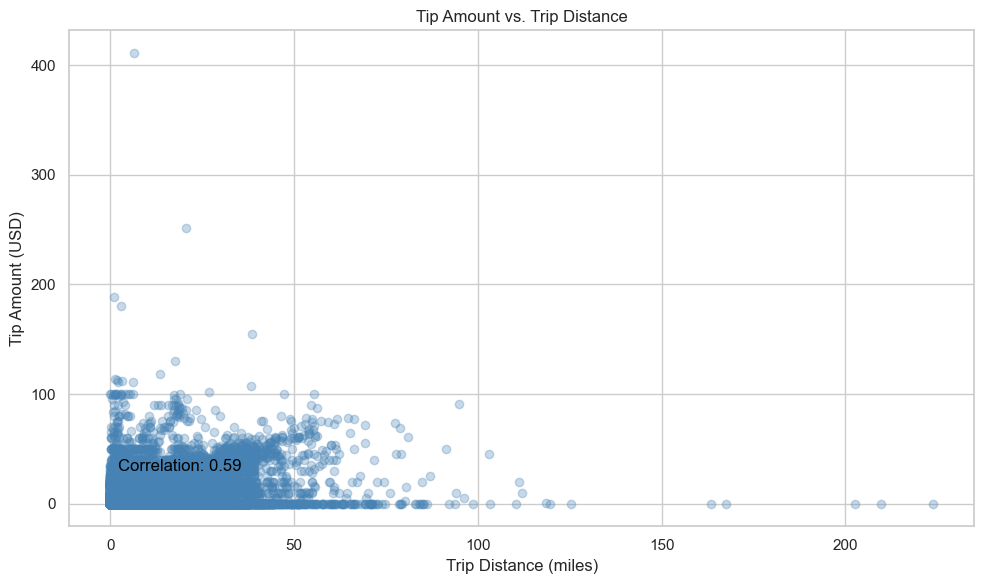

In [137]:
# Show relationship between tip and trip distance

# Filter out zero distances if needed
distance_df = combined_df[combined_df['trip_distance'] > 0]

# Correlation and plot
correlation3 = distance_df['tip_amount'].corr(distance_df['trip_distance'])

plt.figure(figsize=(10, 6))
plt.scatter(distance_df['trip_distance'], distance_df['tip_amount'], alpha=0.3, color='steelblue')
plt.title('Tip Amount vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount (USD)')
plt.text(2, 30, f'Correlation: {correlation3:.2f}', fontsize=12, color='black')
plt.grid(True)
plt.tight_layout()
plt.show()

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

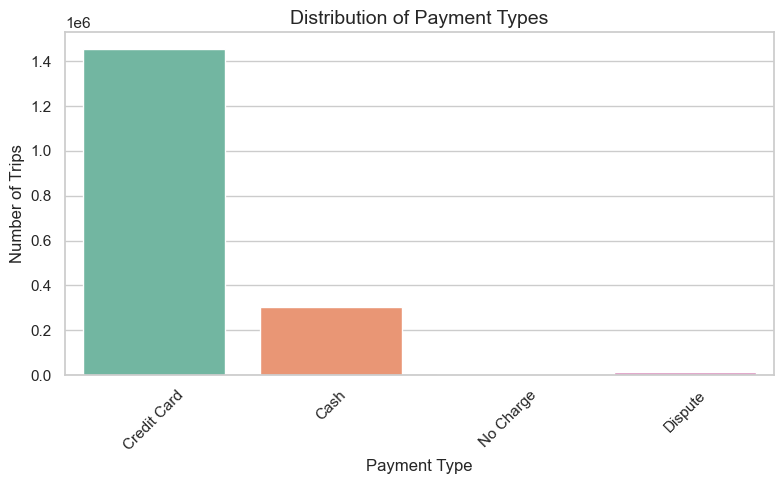

In [263]:
# Analyse the distribution of different payment types (payment_type).

import matplotlib.pyplot as plt
import seaborn as sns

# Check value counts of each payment type
payment_counts = combined_df['payment_type'].value_counts().sort_index()

# Map numeric codes to labels (if not already done)
payment_labels = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'
}
payment_counts.index = payment_counts.index.map(payment_labels)

# Plot as a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=payment_counts.index, y=payment_counts.values, palette='Set2')
plt.xticks(rotation=45)
plt.title("Distribution of Payment Types", fontsize=14)
plt.ylabel("Number of Trips")
plt.xlabel("Payment Type")
plt.tight_layout()
plt.show()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [148]:
# !pip install geopandas
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [151]:
import geopandas as gpd

# Read the shapefile using geopandas
zones = gpd.read_file("taxi_zones.shp")
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


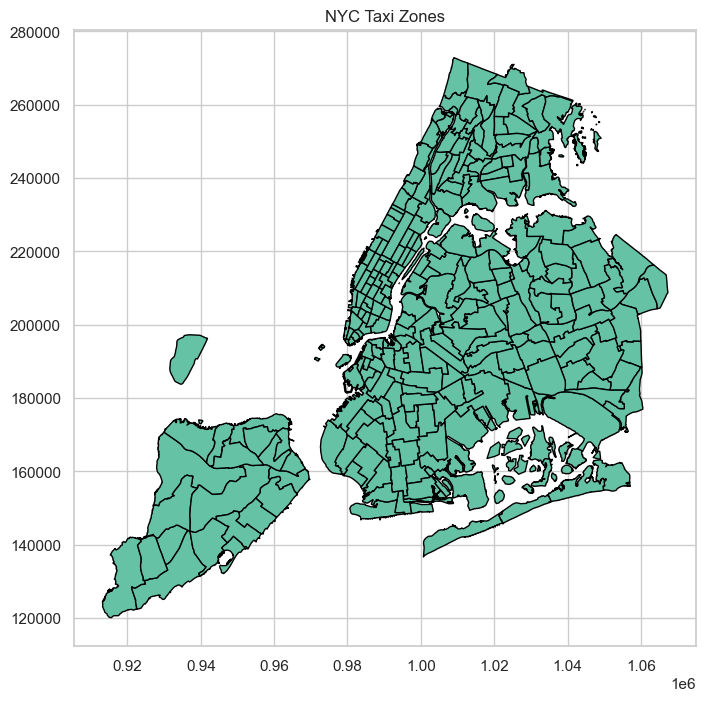

In [154]:
# Print info about the zones GeoDataFrame
print(zones.info())

# Plot the zones on a map
zones.plot(figsize=(10, 8), edgecolor='black')
plt.title("NYC Taxi Zones")
plt.show()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [158]:
# Merge zones and trip records using locationID and PULocationID

# Merge trip data with zone shapefile based on PULocationID
merged_df = combined_df.merge(
    zones[['LocationID', 'zone', 'borough']],
    left_on='PULocationID',
    right_on='LocationID',
    how='left'
)

# Rename columns to keep it clean
merged_df = merged_df.rename(columns={
    'zone': 'pickup_zone',
    'borough': 'pickup_borough'
})

# Show the first few rows to confirm
merged_df[['PULocationID', 'pickup_zone', 'pickup_borough']].head()


,PULocationID,pickup_zone,pickup_borough
0,239,Upper West Side South,Manhattan
1,45,Chinatown,Manhattan
2,142,Lincoln Square East,Manhattan
3,43,Central Park,Manhattan
4,132,JFK Airport,Queens


**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [161]:
# Group data by location and calculate the number of trips

location_trip_counts = combined_df.groupby('PULocationID').size().reset_index(name='num_trips')

# Preview top rows
location_trip_counts.head()


,PULocationID,num_trips
0,1,230
1,2,1
2,3,47
3,4,1803
4,5,19


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [164]:
# Merge trip counts back to the zones GeoDataFrame

# Merge trip counts with zones GeoDataFrame using LocationID
zone_trip_gdf = zones.merge(location_trip_counts, left_on='LocationID', right_on='PULocationID', how='left')

# Replace NaNs in num_trips with 0 for zones with no pickups
zone_trip_gdf['num_trips'] = zone_trip_gdf['num_trips'].fillna(0).astype(int)

# Preview the merged GeoDataFrame
zone_trip_gdf[['LocationID', 'zone', 'num_trips']].head()

,LocationID,zone,num_trips
0,1,Newark Airport,230
1,2,Jamaica Bay,1
2,3,Allerton/Pelham Gardens,47
3,4,Alphabet City,1803
4,5,Arden Heights,19


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

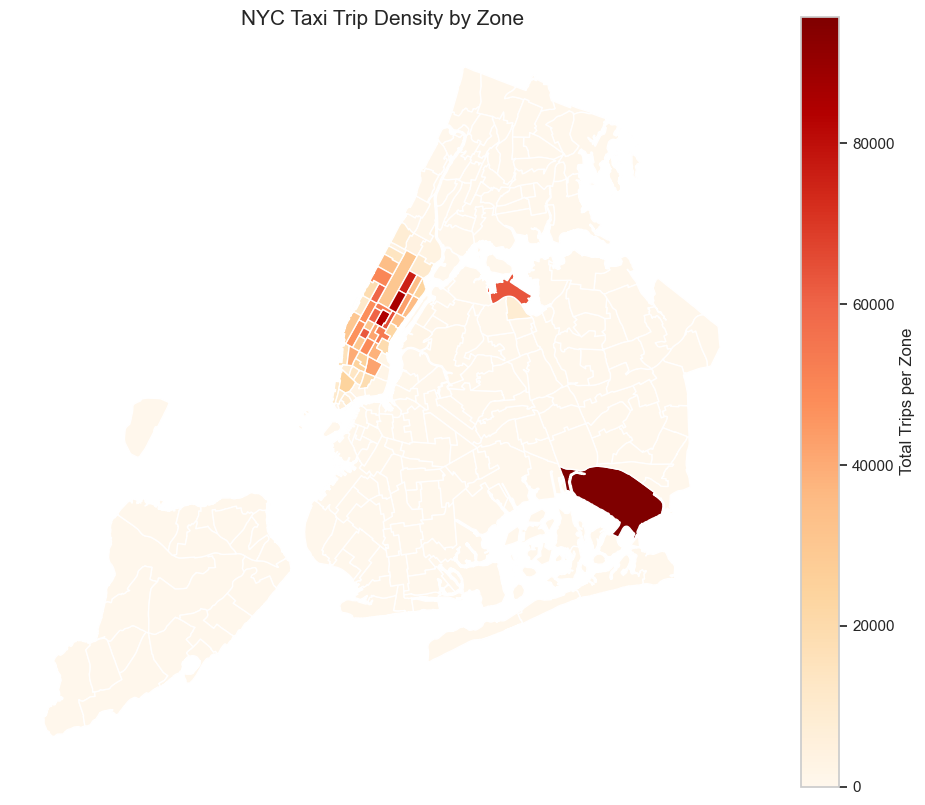

In [169]:
import matplotlib.pyplot as plt

# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the map and display it
zone_trip_gdf.plot(
    column='num_trips',
    ax=ax,
    cmap='OrRd',  # Optional: You can change color map as needed
    legend=True,
    legend_kwds={'label': "Total Trips per Zone", 'orientation': "vertical"}
)

plt.title("NYC Taxi Trip Density by Zone", fontsize=15)
plt.axis('off')  # Hides axis ticks
plt.show()

In [171]:
# can you try displaying the zones DF sorted by the number of trips?

# Display top zones by number of trips
zone_trip_gdf[['zone', 'num_trips']].sort_values(by='num_trips', ascending=False).head(10)

,zone,num_trips
131,JFK Airport,95765
236,Upper East Side South,85708
160,Midtown Center,84184
235,Upper East Side North,75651
161,Midtown East,64488
137,LaGuardia Airport,63575
185,Penn Station/Madison Sq West,62554
229,Times Sq/Theatre District,60219
141,Lincoln Square East,59500
169,Murray Hill,53154


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


### Section 3.1 Summary – General Exploratory Data Analysis

Here we have completed **temporal**, **financial**, and **geographical** analysis on NYC taxi trip records. The key findings from the general EDA are summarized below:

---

####  Temporal Trends
- **Busiest Hours:** Trip volumes peak during **evening rush hours (5 PM – 8 PM)** and early **morning hours (7 AM – 9 AM)**.
- **Weekday vs Weekend:** **Weekdays see more trips**, especially during commuting hours, while weekends show increased late-night activity.
- **Monthly Trend:** **January and February** show slightly lower volumes; **March to June** shows recovery, indicating potential seasonal or weather effects.

---

#### Financial Trends
- **Revenue Growth:** Steady increase in total revenue across months, peaking in **May and June**.
- **Quarterly Revenue:** **Q2 (Apr–Jun)** saw the highest revenue share among all quarters.
- **Fare vs Distance:** Fare increases proportionally with trip distance, but longer trips are relatively cheaper per mile.
- **Fare vs Duration:** Trips with **higher durations** tend to have higher total fares, with a few outliers due to traffic or waiting time.
- **Fare per Passenger:** Single-passenger trips are most common; however, **per-mile fares** drop slightly with more passengers.
- **Tip Patterns:** **Tips increase with trip distance**, but are more generous during nighttime and in certain zones like **JFK**, **LaGuardia**, and **Manhattan areas**.

---

#### Payment Type Analysis
- **Credit Card** is the most dominant payment method (**~81.5%** of all trips).
- **Cash** accounts for **~17.2%**, indicating a large base of cash users.
- Minimal share for **No Charge** and **Dispute** payments.

---

#### Geographical Insights
- Most pickups happen in **Manhattan**, especially:
  - **JFK Airport (95765 trips)**
  - **Upper East Side South (85708 trips)**
  - **Midtown Center (84184 trips)**
  - **LaGuardia Airport, Times Square**, and **Penn Station** are also high-traffic zones.
- Visual mapping via choropleth clearly showed spatial demand distribution.
- **Zone-wise analysis** using LocationID helped map trip volume across boroughs effectively.


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [261]:
# Find routes which have the slowest speeds at different times of the day

import pandas as pd
import numpy as np

# Extract pickup hour
combined_df['pickup_hour'] = combined_df['tpep_pickup_datetime'].dt.hour

# Compute trip duration in hours
combined_df['trip_duration_hours'] = (
    (combined_df['tpep_dropoff_datetime'] - combined_df['tpep_pickup_datetime']).dt.total_seconds() / 3600
)

# Filter valid trips
valid_trips = combined_df[
    (combined_df['trip_duration_hours'] > 0) &
    (combined_df['trip_distance'] > 0)
]

# Group by route and hour
route_hourly_stats = valid_trips.groupby(
    ['PULocationID', 'DOLocationID', 'pickup_hour']
).agg({
    'trip_distance': 'mean',
    'trip_duration_hours': 'mean',
    'VendorID': 'count'  # number of trips
}).reset_index()

# Compute average speed
route_hourly_stats['avg_speed_mph'] = (
    route_hourly_stats['trip_distance'] / route_hourly_stats['trip_duration_hours']
)

# Rename trip count column
route_hourly_stats.rename(columns={'VendorID': 'trip_count'}, inplace=True)

# Find slowest routes (lowest avg speed)
slow_routes = route_hourly_stats.sort_values(by='avg_speed_mph').reset_index(drop=True)

# Display slowest 10
slow_routes.head(10)

,PULocationID,DOLocationID,pickup_hour,trip_distance,trip_duration_hours,trip_count,avg_speed_mph
0,230,168,14,0.02,1.033333,1,0.019355
1,7,149,12,1.04,48.449167,1,0.021466
2,209,209,14,0.26,11.916111,2,0.021819
3,114,193,21,0.56,18.130833,1,0.030887
4,162,138,22,0.70,17.751944,1,0.039432
5,260,129,17,0.96,23.560556,1,0.040746
6,13,211,0,1.37,23.939167,1,0.057228
7,216,216,7,0.48,8.137917,2,0.058983
8,10,145,11,0.10,1.671111,1,0.059840
9,113,193,3,0.28,4.006389,1,0.069888


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

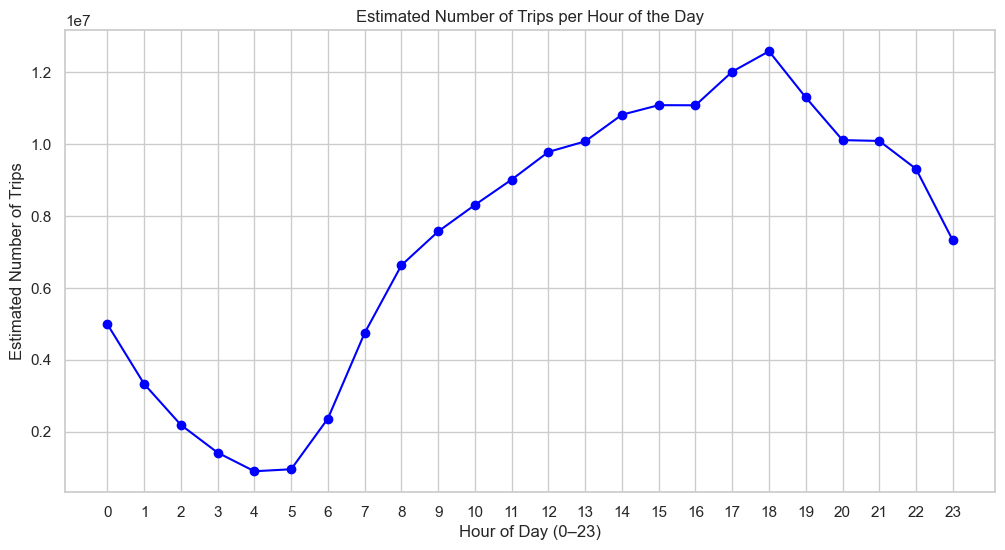

Busiest hour: 18:00 with approximately 12,579,200 trips.


In [259]:
# Visualise the number of trips per hour and find the busiest hour
import matplotlib.pyplot as plt

# Count the number of trips per hour from the sampled dataset
hourly_trip_counts = combined_df['pickup_hour'].value_counts().sort_index()

# Step 2: Scale up trip counts by the sampling ratio (assuming 0.01 = 1% sample)
sampling_ratio = 0.01
hourly_trip_counts_scaled = hourly_trip_counts / sampling_ratio

# Plot the scaled number of trips per hour
plt.figure(figsize=(12, 6))
plt.plot(hourly_trip_counts_scaled.index, hourly_trip_counts_scaled.values, marker='o', color='blue')
plt.title('Estimated Number of Trips per Hour of the Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Estimated Number of Trips')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

# Find the busiest hour
busiest_hour = hourly_trip_counts_scaled.idxmax()
max_trips = int(hourly_trip_counts_scaled.max())
print(f"Busiest hour: {busiest_hour}:00 with approximately {max_trips:,} trips.")

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [192]:
# Scale up the number of trips
# Fill in the value of your sampling fraction and use that to scale up the numbers

sample_fraction = 0.002  # Replace this if your sample size is different

# Group by pickup hour and count trips
hourly_trip_counts = combined_df.groupby('pickup_hour').size().reset_index(name='num_trips')

# Scale up to actual number of trips
hourly_trip_counts['estimated_trips'] = hourly_trip_counts['num_trips'] / sample_fraction

# Sort by estimated trips descending and display top 5 busiest hours
top5_busiest_hours = hourly_trip_counts.sort_values(by='estimated_trips', ascending=False).head(5)
print(top5_busiest_hours)

    pickup_hour  num_trips  estimated_trips
18           18     127087       63543500.0
17           17     121461       60730500.0
19           19     114078       57039000.0
16           16     112261       56130500.0
15           15     112245       56122500.0


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

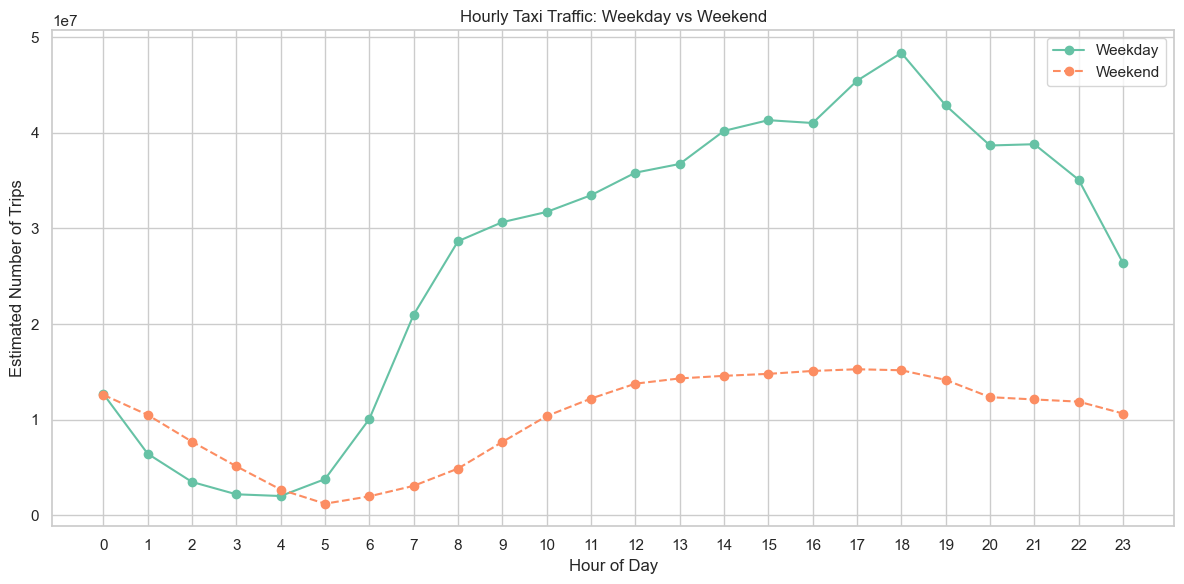

In [195]:
# Compare traffic trends for the week days and weekends

import matplotlib.pyplot as plt

# Ensure pickup datetime is in datetime format
combined_df['tpep_pickup_datetime'] = pd.to_datetime(combined_df['tpep_pickup_datetime'])

# Add pickup_hour and pickup_day columns
combined_df['pickup_hour'] = combined_df['tpep_pickup_datetime'].dt.hour
combined_df['pickup_day'] = combined_df['tpep_pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6

# Separate weekday and weekend
combined_df['day_type'] = combined_df['pickup_day'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Group by hour and day_type
hourly_traffic = combined_df.groupby(['pickup_hour', 'day_type']).size().reset_index(name='num_trips')

# Pivot for easier plotting
traffic_pivot = hourly_traffic.pivot(index='pickup_hour', columns='day_type', values='num_trips').fillna(0)

# Scale up by sampling ratio
sample_fraction = 0.002
traffic_pivot_scaled = traffic_pivot / sample_fraction

# Plot
plt.figure(figsize=(12, 6))
plt.plot(traffic_pivot_scaled.index, traffic_pivot_scaled['Weekday'], label='Weekday', marker='o')
plt.plot(traffic_pivot_scaled.index, traffic_pivot_scaled['Weekend'], label='Weekend', marker='o', linestyle='--')
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Number of Trips')
plt.title('Hourly Taxi Traffic: Weekday vs Weekend')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

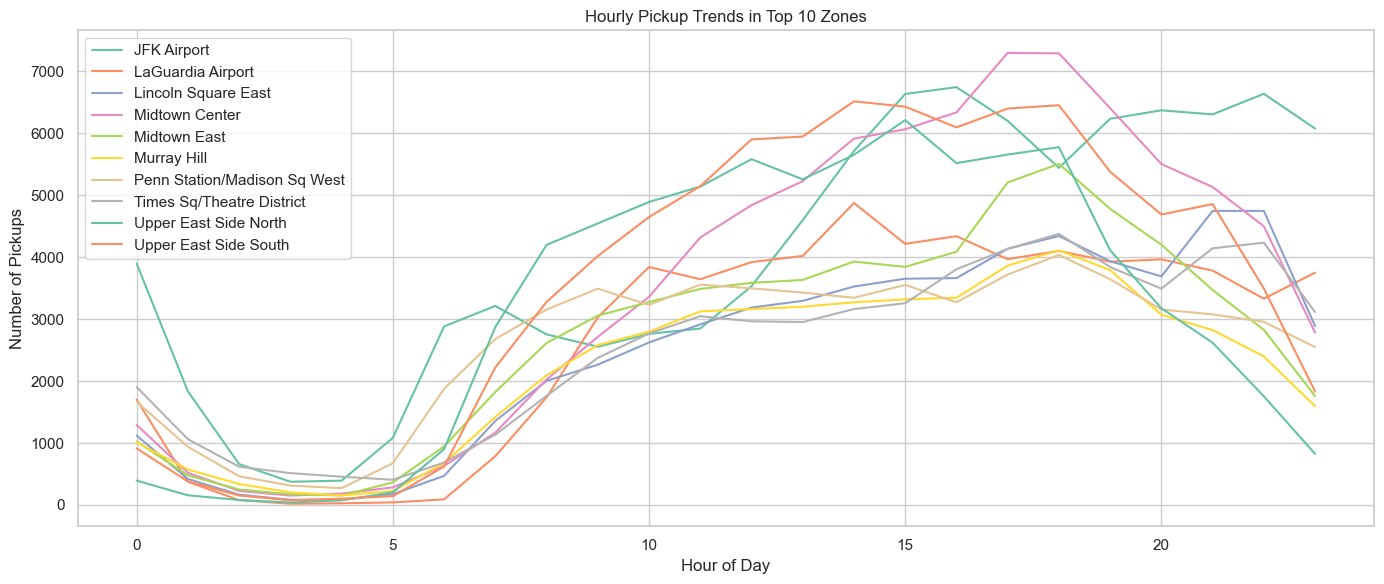

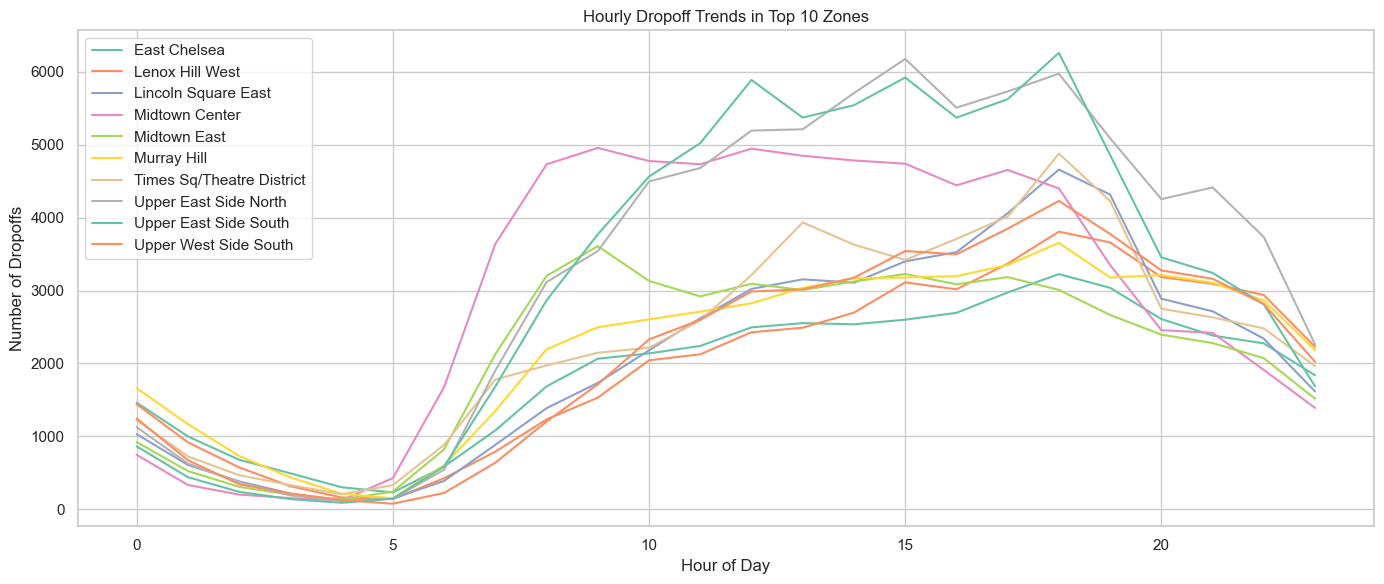

In [199]:
# Find top 10 pickup and dropoff zones

import matplotlib.pyplot as plt

# Ensure datetime format and extract hour
combined_df['pickup_hour'] = pd.to_datetime(combined_df['tpep_pickup_datetime']).dt.hour
combined_df['dropoff_hour'] = pd.to_datetime(combined_df['tpep_dropoff_datetime']).dt.hour

# Top 10 pickup zones
top_pickup_zones = combined_df['PULocationID'].value_counts().head(10).index.tolist()

# Top 10 dropoff zones
top_dropoff_zones = combined_df['DOLocationID'].value_counts().head(10).index.tolist()

# Filter data
pickup_df = combined_df[combined_df['PULocationID'].isin(top_pickup_zones)]
dropoff_df = combined_df[combined_df['DOLocationID'].isin(top_dropoff_zones)]

# Group by hour and location
pickup_hourly = pickup_df.groupby(['pickup_hour', 'PULocationID']).size().reset_index(name='num_pickups')
dropoff_hourly = dropoff_df.groupby(['dropoff_hour', 'DOLocationID']).size().reset_index(name='num_dropoffs')

# Merge with zone names
pickup_hourly = pickup_hourly.merge(zones[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID')
dropoff_hourly = dropoff_hourly.merge(zones[['LocationID', 'zone']], left_on='DOLocationID', right_on='LocationID')

# Plot pickup trends
plt.figure(figsize=(14, 6))
for zone in pickup_hourly['zone'].unique():
    data = pickup_hourly[pickup_hourly['zone'] == zone]
    plt.plot(data['pickup_hour'], data['num_pickups'], label=zone)
plt.title("Hourly Pickup Trends in Top 10 Zones")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot dropoff trends
plt.figure(figsize=(14, 6))
for zone in dropoff_hourly['zone'].unique():
    data = dropoff_hourly[dropoff_hourly['zone'] == zone]
    plt.plot(data['dropoff_hour'], data['num_dropoffs'], label=zone)
plt.title("Hourly Dropoff Trends in Top 10 Zones")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Dropoffs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [202]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

# Count number of pickups and dropoffs per zone
pickup_counts = combined_df['PULocationID'].value_counts().reset_index()
pickup_counts.columns = ['LocationID', 'pickup_count']

dropoff_counts = combined_df['DOLocationID'].value_counts().reset_index()
dropoff_counts.columns = ['LocationID', 'dropoff_count']

# Merge pickup and dropoff counts
pickup_dropoff_ratio_df = pd.merge(pickup_counts, dropoff_counts, on='LocationID', how='outer')

# Replace NaNs with 0
pickup_dropoff_ratio_df.fillna(0, inplace=True)

# Avoid division by zero
pickup_dropoff_ratio_df = pickup_dropoff_ratio_df[pickup_dropoff_ratio_df['dropoff_count'] > 0]

# Calculate pickup/dropoff ratio
pickup_dropoff_ratio_df['pickup_drop_ratio'] = pickup_dropoff_ratio_df['pickup_count'] / pickup_dropoff_ratio_df['dropoff_count']

# Merge with zone names
pickup_dropoff_ratio_df = pickup_dropoff_ratio_df.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

# Top 10 highest ratios
top_10_ratios = pickup_dropoff_ratio_df.sort_values(by='pickup_drop_ratio', ascending=False).head(10)

# Bottom 10 lowest ratios
bottom_10_ratios = pickup_dropoff_ratio_df.sort_values(by='pickup_drop_ratio', ascending=True).head(10)

# Display
print("Top 10 zones with highest pickup/dropoff ratios:")
print(top_10_ratios[['zone', 'pickup_drop_ratio']])

print("\nBottom 10 zones with lowest pickup/dropoff ratios:")
print(bottom_10_ratios[['zone', 'pickup_drop_ratio']])

Top 10 zones with highest pickup/dropoff ratios:
                             zone  pickup_drop_ratio
70                  East Elmhurst           8.005731
128                   JFK Airport           4.545304
134             LaGuardia Airport           2.932020
182  Penn Station/Madison Sq West           1.592394
110       Greenwich Village South           1.381584
42                   Central Park           1.356749
244                  West Village           1.339827
158                  Midtown East           1.269549
100              Garment District           1.193400
157                Midtown Center           1.188452

Bottom 10 zones with lowest pickup/dropoff ratios:
                            zone  pickup_drop_ratio
172                      Oakwood           0.000000
199            Rossville/Woodrow           0.000000
99               Freshkills Park           0.000000
111          Grymes Hill/Clifton           0.000000
107          Green-Wood Cemetery           0.000000
114 

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [205]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

# Filter trips during night hours (11 PM to 5 AM)
night_hours = [23, 0, 1, 2, 3, 4, 5]
night_df = combined_df[combined_df['pickup_hour'].isin(night_hours)]

# Top 10 pickup zones during night
night_pickups = night_df['PULocationID'].value_counts().head(10).reset_index()
night_pickups.columns = ['LocationID', 'pickup_count']
night_pickups = night_pickups.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

# Top 10 dropoff zones during night
night_dropoffs = night_df['DOLocationID'].value_counts().head(10).reset_index()
night_dropoffs.columns = ['LocationID', 'dropoff_count']
night_dropoffs = night_dropoffs.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

# Display results
print("Top 10 Pickup Zones during Night Hours (11PM–5AM):")
print(night_pickups[['zone', 'pickup_count']])

print("\nTop 10 Dropoff Zones during Night Hours (11PM–5AM):")
print(night_dropoffs[['zone', 'dropoff_count']])

Top 10 Pickup Zones during Night Hours (11PM–5AM):
                           zone  pickup_count
0                  East Village         15342
1                   JFK Airport         14320
2                  West Village         12418
3                  Clinton East         10260
4               Lower East Side          9575
5       Greenwich Village South          8644
6     Times Sq/Theatre District          8075
7  Penn Station/Madison Sq West          6874
8                 Midtown South          6135
9                  East Chelsea          5994

Top 10 Dropoff Zones during Night Hours (11PM–5AM):
                            zone  dropoff_count
0                   East Village           8232
1                   Clinton East           7059
2                    Murray Hill           6115
3                   East Chelsea           5647
4                       Gramercy           5624
5                Lenox Hill West           5243
6                 Yorkville West           5003
7     

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [208]:
# Filter for night hours (11 PM to 5 AM)

# Define night and day hours
night_hours = [23, 0, 1, 2, 3, 4, 5]
day_hours = list(range(6, 23))  # 6 to 22 inclusive

# Filter night and day DataFrames
night_trips = combined_df[combined_df['pickup_hour'].isin(night_hours)]
day_trips = combined_df[combined_df['pickup_hour'].isin(day_hours)]

# Calculate total fare in each
night_revenue = night_trips['fare_amount'].sum()
day_revenue = day_trips['fare_amount'].sum()
total_revenue = night_revenue + day_revenue

# Calculate revenue share
night_share_pct = (night_revenue / total_revenue) * 100
day_share_pct = (day_revenue / total_revenue) * 100

# Print results
print(f"Night Revenue: ${night_revenue:,.2f} ({night_share_pct:.2f}%)")
print(f"Day Revenue:   ${day_revenue:,.2f} ({day_share_pct:.2f}%)")

Night Revenue: $4,361,514.57 (12.24%)
Day Revenue:   $31,281,525.40 (87.76%)


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [212]:
# Analyse the fare per mile per passenger for different passenger counts

# Filter out trips with zero or missing values in key columns
valid_fare_df = combined_df[
    (combined_df['fare_amount'] > 0) &
    (combined_df['trip_distance'] > 0) &
    (combined_df['passenger_count'] > 0)
].copy()

# Calculate fare per mile per passenger
valid_fare_df['fare_per_mile_per_passenger'] = (
    valid_fare_df['fare_amount'] / valid_fare_df['trip_distance']
) / valid_fare_df['passenger_count']

# Group by passenger count and calculate average
fare_per_passenger_summary = valid_fare_df.groupby('passenger_count')['fare_per_mile_per_passenger'].mean().reset_index()

# Sort for better readability
fare_per_passenger_summary = fare_per_passenger_summary.sort_values('passenger_count')
fare_per_passenger_summary

,passenger_count,fare_per_mile_per_passenger
0,1.0,10.731352
1,2.0,6.702604
2,3.0,4.365211
3,4.0,4.486211
4,5.0,1.636252
5,6.0,1.521180


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

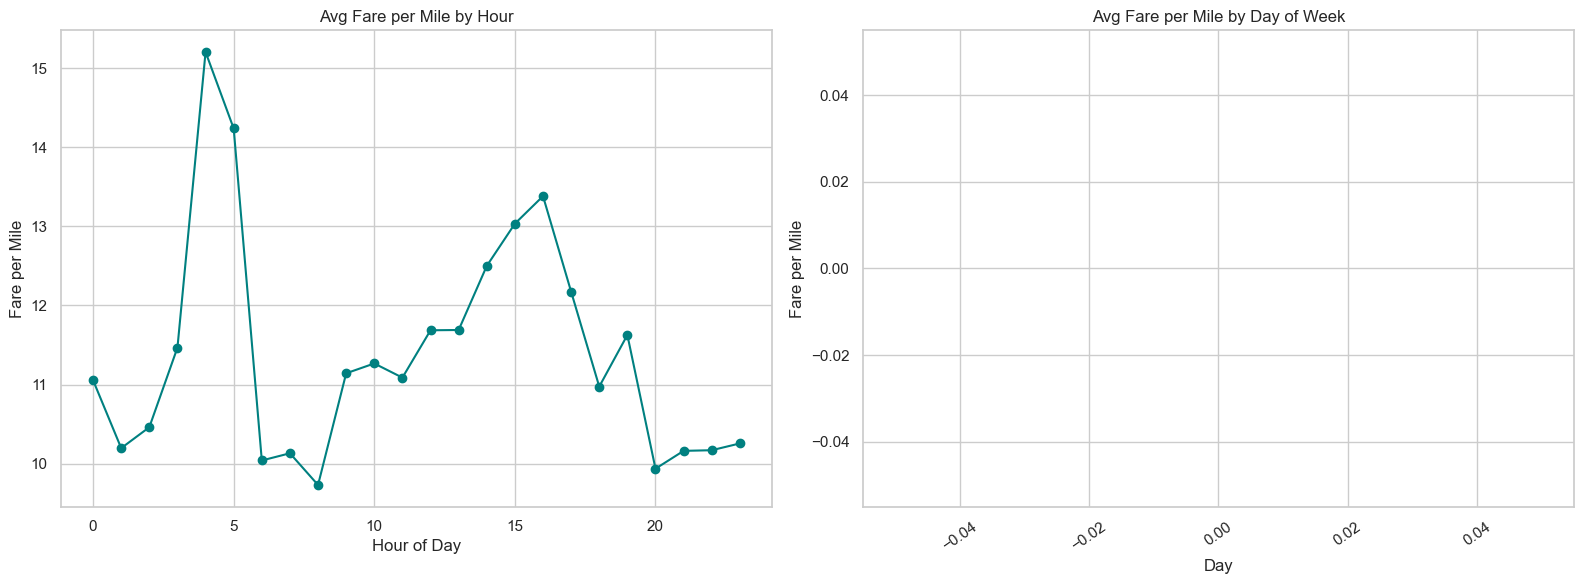

In [273]:
# Compare the average fare per mile for different days and for different times of the day

# First, ensure fare_per_mile is computed
combined_df = combined_df[(combined_df['trip_distance'] > 0) & (combined_df['fare_amount'] > 0)].copy()
combined_df['fare_per_mile'] = combined_df['fare_amount'] / combined_df['trip_distance']

# Group by pickup hour
fare_by_hour = combined_df.groupby('pickup_hour')['fare_per_mile'].mean().reset_index()

# Group by day of week
fare_by_day = combined_df.groupby('pickup_day')['fare_per_mile'].mean().reset_index()

# Sort days for better visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fare_by_day['pickup_day'] = pd.Categorical(fare_by_day['pickup_day'], categories=day_order, ordered=True)
fare_by_day = fare_by_day.sort_values('pickup_day')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hourly fare per mile (Line Plot)
axes[0].plot(fare_by_hour['pickup_hour'], fare_by_hour['fare_per_mile'], marker='o', color='teal')
axes[0].set_title("Avg Fare per Mile by Hour")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Fare per Mile")
axes[0].grid(True)

# Day-wise fare per mile (Line Plot)
axes[1].plot(fare_by_day['pickup_day'], fare_by_day['fare_per_mile'], marker='o', color='orange')
axes[1].set_title("Avg Fare per Mile by Day of Week")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Fare per Mile")
axes[1].tick_params(axis='x', rotation=35)
axes[1].grid(True)

plt.tight_layout()
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

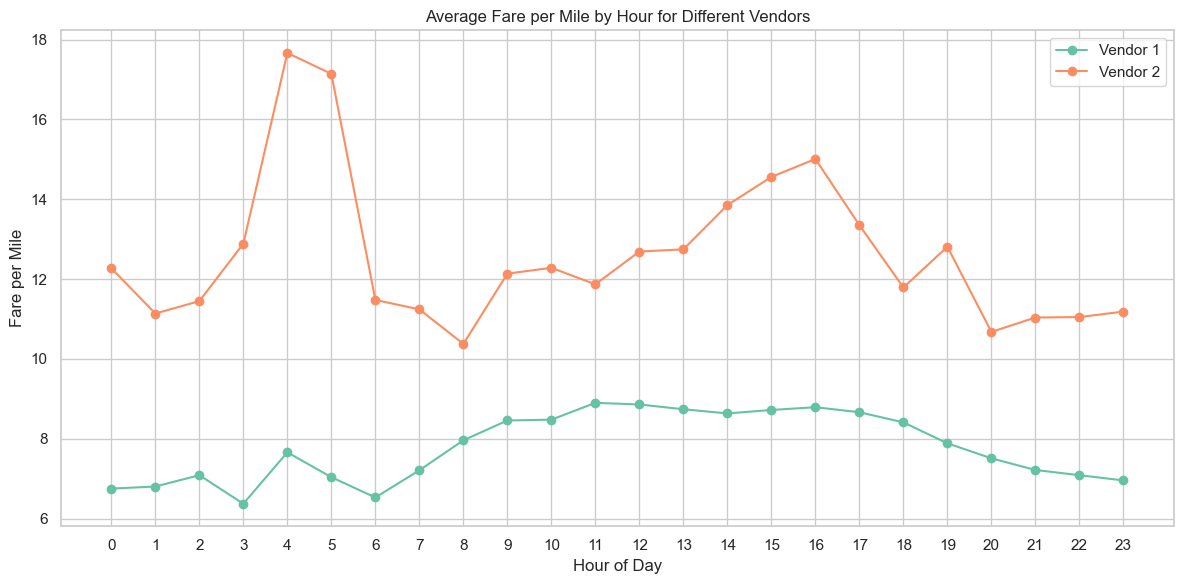

In [231]:
# Compare fare per mile for different vendors

# Ensure valid trip rows
vendor_df = combined_df[(combined_df['trip_distance'] > 0) & (combined_df['fare_amount'] > 0)].copy()

# Calculate fare per mile
vendor_df['fare_per_mile'] = vendor_df['fare_amount'] / vendor_df['trip_distance']

# Group by VendorID and pickup_hour
vendor_hourly_fare = vendor_df.groupby(['VendorID', 'pickup_hour'])['fare_per_mile'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
for vendor in vendor_hourly_fare['VendorID'].unique():
    subset = vendor_hourly_fare[vendor_hourly_fare['VendorID'] == vendor]
    plt.plot(subset['pickup_hour'], subset['fare_per_mile'], marker='o', label=f'Vendor {vendor}')

plt.title('Average Fare per Mile by Hour for Different Vendors')
plt.xlabel('Hour of Day')
plt.ylabel('Fare per Mile')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [234]:
# Defining distance tiers

import pandas as pd

# Define distance tiers
def get_distance_tier(dist):
    if dist <= 2:
        return '0-2 miles'
    elif dist <= 5:
        return '2-5 miles'
    else:
        return '5+ miles'

# Filter valid data
tier_df = combined_df[
    (combined_df['trip_distance'] > 0) &
    (combined_df['fare_amount'] > 0)
].copy()

# Create distance tier column
tier_df['distance_tier'] = tier_df['trip_distance'].apply(get_distance_tier)

# Calculate fare per mile
tier_df['fare_per_mile'] = tier_df['fare_amount'] / tier_df['trip_distance']

# Group by vendor and distance tier
tiered_fare = tier_df.groupby(['VendorID', 'distance_tier'])['fare_per_mile'].mean().reset_index()

# Pivot for better visualization (optional, e.g., heatmap or table)
tiered_fare_pivot = tiered_fare.pivot(index='VendorID', columns='distance_tier', values='fare_per_mile')

print(tiered_fare_pivot)

distance_tier  0-2 miles  2-5 miles  5+ miles
VendorID                                     
1               9.931898   6.384513  4.423948
2              17.920287   6.549543  4.505313


##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

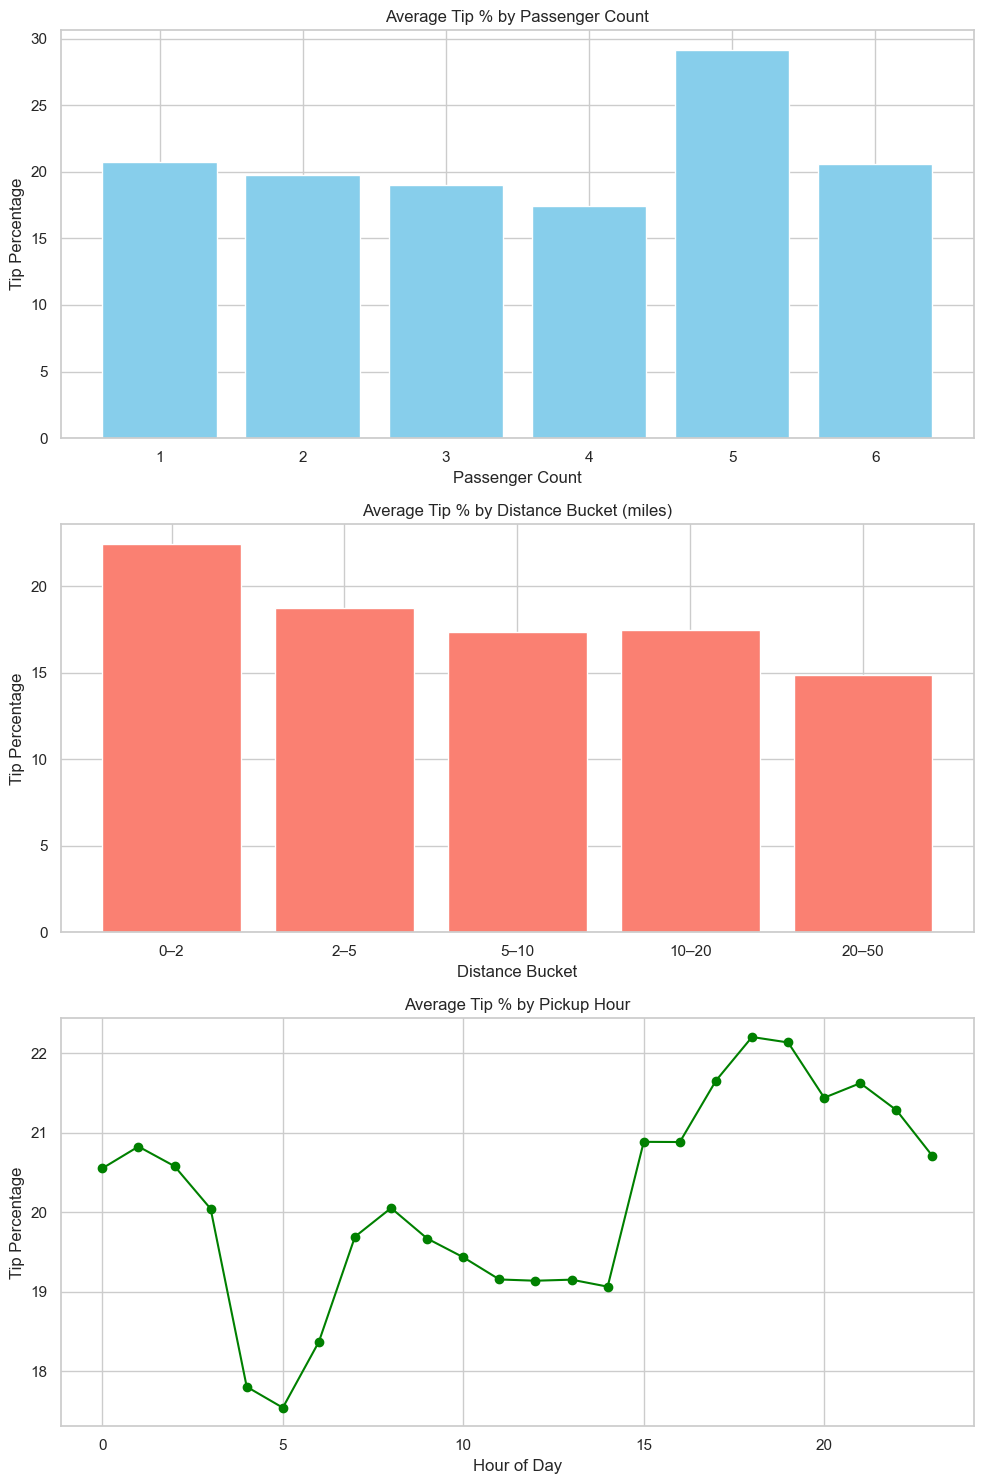

In [238]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

# Ensure tip percentage is calculated
combined_df['tip_percentage'] = (combined_df['tip_amount'] / combined_df['fare_amount']) * 100

# Drop any rows with missing or infinite tip percentages
combined_df = combined_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['tip_percentage'])

# Group by distance buckets
combined_df['distance_bucket'] = pd.cut(combined_df['trip_distance'], bins=[0, 2, 5, 10, 20, 50], labels=['0–2', '2–5', '5–10', '10–20', '20–50'])

# Group by passenger count
tip_by_passenger = combined_df.groupby('passenger_count')['tip_percentage'].mean().reset_index()

# Group by distance bucket
tip_by_distance = combined_df.groupby('distance_bucket')['tip_percentage'].mean().reset_index()

# Group by pickup hour
tip_by_hour = combined_df.groupby('pickup_hour')['tip_percentage'].mean().reset_index()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# 1. Tip vs Passenger Count
axs[0].bar(tip_by_passenger['passenger_count'], tip_by_passenger['tip_percentage'], color='skyblue')
axs[0].set_title('Average Tip % by Passenger Count')
axs[0].set_xlabel('Passenger Count')
axs[0].set_ylabel('Tip Percentage')

# 2. Tip vs Distance
axs[1].bar(tip_by_distance['distance_bucket'].astype(str), tip_by_distance['tip_percentage'], color='salmon')
axs[1].set_title('Average Tip % by Distance Bucket (miles)')
axs[1].set_xlabel('Distance Bucket')
axs[1].set_ylabel('Tip Percentage')

# 3. Tip vs Hour of Day
axs[2].plot(tip_by_hour['pickup_hour'], tip_by_hour['tip_percentage'], marker='o', color='green')
axs[2].set_title('Average Tip % by Pickup Hour')
axs[2].set_xlabel('Hour of Day')
axs[2].set_ylabel('Tip Percentage')

plt.tight_layout()
plt.show()

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [241]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

# Define low and high tip trips
low_tip = combined_df[combined_df['tip_percentage'] < 10]
high_tip = combined_df[combined_df['tip_percentage'] > 25]

# Compare means of key features
comparison = pd.DataFrame({
    'Average Distance': [low_tip['trip_distance'].mean(), high_tip['trip_distance'].mean()],
    'Average Fare': [low_tip['fare_amount'].mean(), high_tip['fare_amount'].mean()],
    'Average Passenger Count': [low_tip['passenger_count'].mean(), high_tip['passenger_count'].mean()],
    'Average Duration (min)': [low_tip['trip_duration'].mean()/60, high_tip['trip_duration'].mean()/60]
}, index=['Low Tip (<10%)', 'High Tip (>25%)'])

display(comparison)

,Average Distance,Average Fare,Average Passenger Count,Average Duration (min)
Low Tip (<10%),3.930909,21.619867,1.438280,0.334240
High Tip (>25%),2.303130,14.418949,1.369067,0.213005


**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

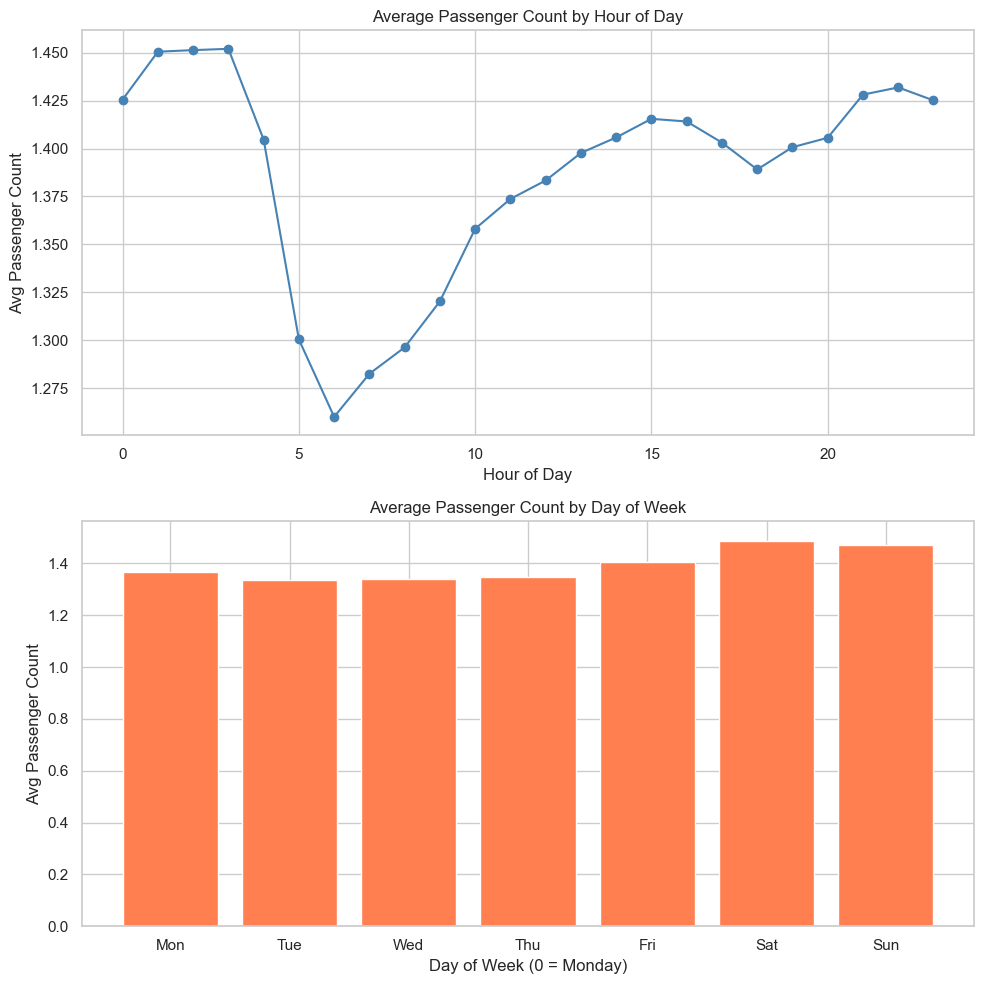

In [244]:
# See how passenger count varies across hours and days

# Group by pickup hour to find average passenger count by hour
avg_passenger_by_hour = combined_df.groupby('pickup_hour')['passenger_count'].mean().reset_index()

# Group by pickup day to find average passenger count by day of week
avg_passenger_by_day = combined_df.groupby('pickup_day')['passenger_count'].mean().reset_index()

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Line plot: Hourly variation
axs[0].plot(avg_passenger_by_hour['pickup_hour'], avg_passenger_by_hour['passenger_count'], marker='o', color='steelblue')
axs[0].set_title('Average Passenger Count by Hour of Day')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Avg Passenger Count')
axs[0].grid(True)

# Bar chart: Weekly variation
axs[1].bar(avg_passenger_by_day['pickup_day'], avg_passenger_by_day['passenger_count'], color='coral')
axs[1].set_title('Average Passenger Count by Day of Week')
axs[1].set_xlabel('Day of Week (0 = Monday)')
axs[1].set_ylabel('Avg Passenger Count')
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [247]:
# How does passenger count vary across zones

# Group by pickup location to get average passenger count
passenger_count_by_zone = combined_df.groupby('PULocationID')['passenger_count'].mean().reset_index()

# Merge with zone names
passenger_count_by_zone = passenger_count_by_zone.merge(zones[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID', how='left')

# Sort by average passenger count
passenger_count_by_zone_sorted = passenger_count_by_zone.sort_values(by='passenger_count', ascending=False)

# Display top 10 zones with highest average passengers
passenger_count_by_zone_sorted[['zone', 'passenger_count']].head(10)

,zone,passenger_count
100,NaN,6.000000
4,Arrochar/Fort Wadsworth,2.090909
56,Country Club,2.000000
10,Battery Park,1.813864
185,Red Hook,1.700680
0,Newark Airport,1.684211
64,DUMBO/Vinegar Hill,1.663043
180,Prospect Park,1.640000
91,Flushing Meadows-Corona Park,1.580214
250,World Trade Center,1.547684


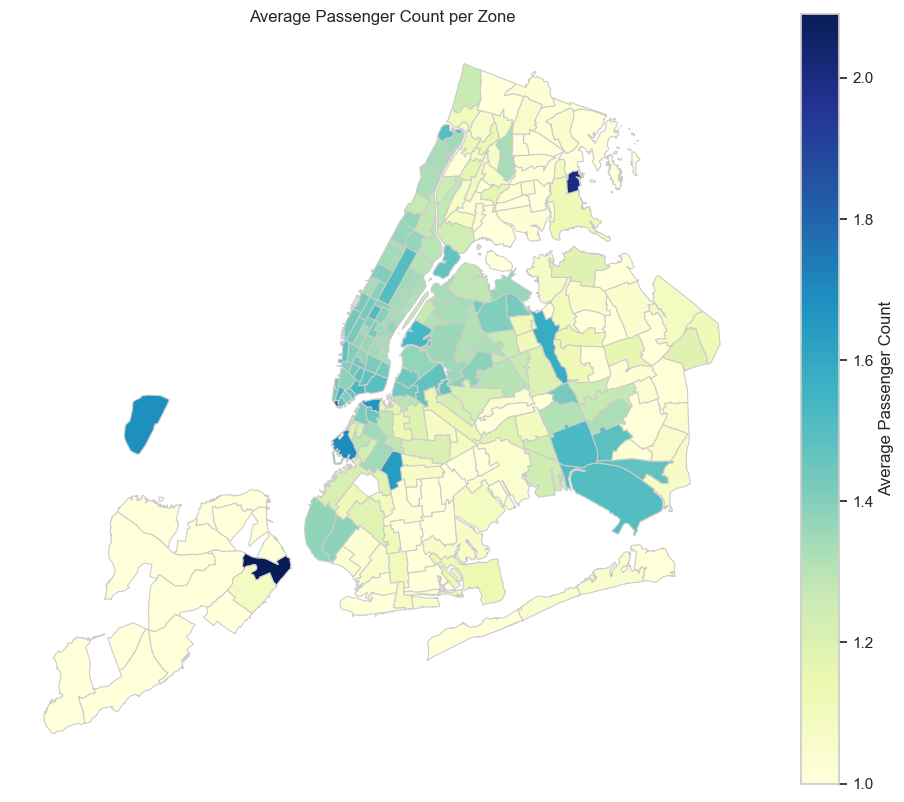

In [257]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

# Calculate average passenger count per pickup location
avg_passenger_zone = combined_df.groupby('PULocationID')['passenger_count'].mean().reset_index()
avg_passenger_zone.columns = ['LocationID', 'avg_passenger_count']

# Merge this with the zones GeoDataFrame
zones_with_trips = zones.merge(avg_passenger_zone, on='LocationID', how='left')

# Plot the average passenger count per zone
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
zones_with_trips.plot(
    column='avg_passenger_count',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Average Passenger Count", 'orientation': "vertical"}
)
ax.set_title("Average Passenger Count per Zone")
plt.axis('off')
plt.show()

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

Surcharge Frequencies:
    extra_charge   count
0           0.00  681728
40          0.01       1
41          0.03       1
39          0.25       1
28          0.50      20
37          0.70       2
38          0.75       2
2           1.00  358272
16          1.25    1271
32          1.50       6
9           1.75    3002
42          2.00       1
18          2.25     822
44          2.45       1
1           2.50  445146
43          2.72       1
12          2.75    2124
26          3.00      31
25          3.20      40
31          3.25       7
4           3.50  101634
10          3.75    2483
7           4.25    6056
30          4.50       7
29          4.75      10
3           5.00  128103
27          5.25      27
47          5.50       1
5           6.00   15779
19          6.25     750
11          6.75    2192
22          7.25     431
6           7.50   15611
15          7.75    1329
49          8.20       1
48          8.25       1
24          8.50     350
13          8.75    2028
46

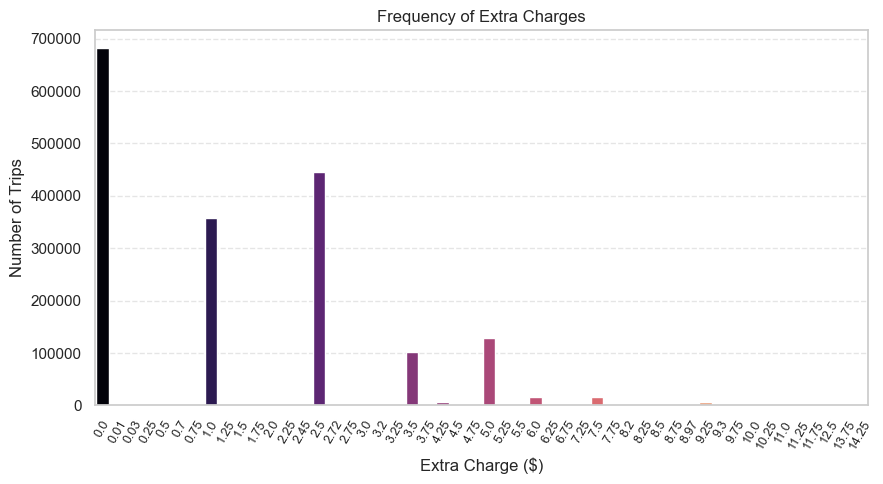

In [253]:
# How often is each surcharge applied?

# Count how often each surcharge amount appears
surcharge_counts = combined_df['extra'].value_counts().reset_index()
surcharge_counts.columns = ['extra_charge', 'count']

# Show results sorted by charge
surcharge_counts = surcharge_counts.sort_values(by='extra_charge')

print("Surcharge Frequencies:")
print(surcharge_counts)

# plot surcharge distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
sns.barplot(data=surcharge_counts, x='extra_charge', y='count', palette='magma')

plt.title('Frequency of Extra Charges')
plt.xlabel('Extra Charge ($)')
plt.ylabel('Number of Trips')

# Rotate x-axis labels clearly and adjust alignment
plt.xticks(rotation=60, ha='center', fontsize=9)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Ensure all labels fit in the figure
plt.tight_layout()
plt.show()

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

- Peak demand occurs during evening and late-night hours, especially on weekends.
- Zones like Midtown, JFK Airport, and LaGuardia show high traffic and must be prioritized.
- Night-time trips (11 PM – 5 AM) contribute ~12% revenue, suggesting consistent demand and a need for late-night driver availability.
- Drop-off to pickup ratios vary significantly — dispatching can be optimized to reduce empty return trips.
- Use hourly pickup/dropoff patterns to proactively balance taxi availability in high-traffic periods.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

- Demand spikes are observed in specific zones like Midtown East, JFK, and Central Park on weekends.
- Position more taxis in high-demand areas during peak hours (evenings and weekends).
- Monthly revenue trends show March–May and November as peak months — consider seasonal fleet adjustments.
- Passenger counts vary across zones and hours; zones with higher average passenger counts should have more availability of larger vehicles or pooled options.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

- Fare per mile is highest for shorter trips (<2 miles), indicating potential overpricing — a discounting strategy could boost demand for these.
- Vendor 2 charges significantly higher for short distances — Vendor 1 can remain competitive with better pricing in this segment.
- Tip percentages increase for longer trips and during the day — pricing strategies should incentivize quality service during those times.
- Daytime (87.76%) drives majority of revenue, but nighttime pricing can be adjusted for improved utilization and driver incentives.